In [1]:
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from glob import glob
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Marta\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
#EXTRAER LOS NOMBRES DE TODOS LOS ARCHIVOS PARA SU POSTERIOR LECTURA Y ORDENARLOS EN ORDEN CRONOLÓGICO
archivos = glob('DATOS/*Semana*.txt')

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):

    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

archivos.sort(key=natural_keys)

In [3]:
archivos

['DATOS\\2017 - Semana 1 (08012017).txt',
 'DATOS\\2017 - Semana 2 (15012017).txt',
 'DATOS\\2017 - Semana 3 (22012017).txt',
 'DATOS\\2017 - Semana 4 (29012017).txt',
 'DATOS\\2017 - Semana 5 (05022017).txt',
 'DATOS\\2017 - Semana 6 (12022017).txt',
 'DATOS\\2017 - Semana 7 (19022017).txt',
 'DATOS\\2017 - Semana 8 (12032017).txt',
 'DATOS\\2017 - Semana 9 (05032017).txt',
 'DATOS\\2017 - Semana 10 (12032017).txt',
 'DATOS\\2017 - Semana 11 (19032017).txt',
 'DATOS\\2017 - Semana 12 (26032017).txt',
 'DATOS\\2017 - Semana 13 (02042017).txt',
 'DATOS\\2017 - Semana 14 (09042017).txt',
 'DATOS\\2017 - Semana 15 (16042017).txt',
 'DATOS\\2017 - Semana 16 (23042017).txt',
 'DATOS\\2017 - Semana 17 (30042017).txt',
 'DATOS\\2017 - Semana 18 (07052017).txt',
 'DATOS\\2017 - Semana 19 (14052017).txt',
 'DATOS\\2017 - Semana 20 (21052017).txt',
 'DATOS\\2017 - Semana 21 (28052017).txt',
 'DATOS\\2017 - Semana 22 (04062017).txt',
 'DATOS\\2017 - Semana 23 (11062017).txt',
 'DATOS\\2017 - Sema

In [4]:
#CREAMOS LOS CSVs VACÍOS PARA ALMACENAR LOS DFs DE CADENA PARA SARIMAX
data_prueba = pd.DataFrame(columns=['Target'])
data_prueba.to_csv('SAR_atres.csv')
data_prueba.to_csv('SAR_sexta.csv')
data_prueba.to_csv('SAR_neox.csv')
data_prueba.to_csv('SAR_nova.csv')
data_prueba.to_csv('SAR_mega.csv')
data_prueba.to_csv('SAR_atreseries.csv')
data_prueba.to_csv('SAR_telecinco.csv')
data_prueba.to_csv('SAR_cuatro.csv')
data_prueba.to_csv('SAR_divinity.csv')
data_prueba.to_csv('SAR_energy.csv')
data_prueba.to_csv('SAR_fdf.csv')
data_prueba.to_csv('SAR_bemad.csv')
data_prueba.to_csv('SAR_dmax.csv')
data_prueba.to_csv('SAR_dkiss.csv')
data_prueba.to_csv('SAR_paramount.csv')
data_prueba.to_csv('SAR_ten.csv')
data_prueba.to_csv('SAR_trece.csv')

data_ml = pd.DataFrame(columns=['Full_date','Hour','Minute','Time','Machine_hour','Date','Day_number','Day_name'
                                ,'Week_day_number','Week_number','Month_name','Month_number','Year','Time_frame'
                                ,'Ordered_timeframe','Channel','Simul_cast_channel','Sales_house','Title/Descrip'
                                , 'Genre','Public','Production_comp','Age_rating','Adults_avg_audience'
                                ,'Audience_checker'])
data_ml.to_csv('df_ml.csv')

In [5]:
#FUNCIÓN PARA CREAR LA COLUMNA DE FRANJAS HORARIAS A PARTIR DE VALOR DE FECHA.
def time_frame (value):
    
    if ((value.time() >= datetime.time(7,0)) & (value.time() < datetime.time(14,0))):
        return 'Morning'
    if ((value.time() >= datetime.time(14,0)) & (value.time() < datetime.time(16,0))):
        return 'Lunch'
    if ((value.time() >= datetime.time(16,0)) & (value.time() < datetime.time(20,30))):
        return 'After'
    if ((value.time() >= datetime.time(20,30)) & (value.time() <= datetime.time(23,59))):
        return 'PT'
    if ((value.time() >= datetime.time(0,0)) & (value.time() < datetime.time(0,30))):
        return 'PT'
    if ((value.time() >= datetime.time(0,30)) & (value.time() < datetime.time(1,30))):
        return 'Late_PT'
    if ((value.time() >= datetime.time(1,30)) & (value.time() < datetime.time(7,0))):
        return 'Night'
    

#FUNCIÓN PARA CREAR EL GRUPO COMERCIAL DE CADA CADENA
def com_group(cadena):
    atres = ['A3','LA SEXTA','NEOX','NOVA','MEGA','ATRESERIES']
    medset = ['T5','CUATRO','DIVINITY','ENERGY','FDF','BEMADtv']
    pulsa = ['DMAX','DKISS','PARAMOUNT NETWORK','TEN','TRECE']
    
    if cadena in atres:
        return 'ATRESMEDIA'
    if cadena in medset:
        return 'MEDIASET'
    if cadena in pulsa:
        return 'PULSA'
    
#FUNCIÓN PARA CREAR LA COLUMNA MULTI_CAST_CHANNEL
def simul_cast(cadena):
    multi = ['NOVA','MEGA','ATRESERIES']
    gcuatro = ['CUATRO','DIVINITY','ENERGY']
    nsf = ['FDF','BEMADtv']
    
    if cadena in multi:
        return 'MULTI'
    if cadena in gcuatro:
        return 'G.CUATRO'
    if cadena in nsf:
        return 'NSF'
    else:
        return cadena
    
#FUNCIÓN PARA CREAR LA COLUMNA ORDERED_TIME_FRAME
def ord_timf(timeframe):
    if timeframe == 'Morning':
        return 1
    if timeframe == 'Lunch':
        return 2
    if timeframe == 'After':
        return 3
    if timeframe == 'PT':
        return 4
    if timeframe == 'Late_PT':
        return 5
    if timeframe == 'Night':
        return 6

#FUNCION PARA SACAR EL ORDINAL DEL DIA DE LA SEMANA
def week_day_ord(day):
    if day == 'Monday':
        return 1
    if day == 'Tuesday':
        return 2
    if day == 'Wednesday':
        return 3
    if day == 'Thursday':
        return 4
    if day == 'Friday':
        return 5
    if day == 'Saturday':
        return 6
    if day == 'Sunday':
        return 7

In [6]:

counter = 0

for arch in archivos:
    
    if counter == len(archivos):
        break
    print(arch)
    #pd.set_option('display.max_columns', None)
    #pd.set_option('display.max_rows', None)
    df = pd.read_csv(arch,error_bad_lines=False,encoding = 'unicode_escape', 
                     header=3, sep='\t', skiprows=[4], skipinitialspace=True, 
                     usecols=['Título','Título/Descripción', 'Cadena', 'Fecha', 'Género','Público objetivo', 
                              'Productora','Calificación de Edad','Ind. 16+ (c/inv.)','Ind. 16+ (c/inv.).1']
                     ,dtype ='str' )

    #ELIMINAMOS LAS CABECERAS DE LOS PROGRAMAS EN LA COLUMNA TÍTULO
    df.dropna(inplace = True)
    df = df[df.Título.str.startswith('<<')]
    df.reset_index(drop = True,inplace = True)

    #ELIMINAMOS LOS SIMBOLOS <> DEL DATA FRAME
    df1 = pd.DataFrame()
    for i in df.columns:
        df1 = pd.concat([df1,df.loc[:,i].str.translate({ord(x): None for x in ('><')})], axis = 1)

    #ESCOJO LAS CADENAS DE INTERÉS
    cadenas_v = ['A3','LA SEXTA','NEOX','NOVA','MEGA','ATRESERIES','T5','CUATRO','DIVINITY','ENERGY','FDF','BEMADtv'
                 ,'DMAX','DKISS','PARAMOUNT NETWORK','TEN','TRECE']
    df1 = df1[df1['Cadena'].isin(cadenas_v)]

    #DIVIDIMOS LA COLUMNA EN DOS PARA PODER OPERAR SOLO CON LA HORA 
    #(NO SE PUEDE PASAR A DATETIME YA QUE NO ESTÁ EN EL RANGO ADECUADO)
    df1[['Hora','Minuto']] = df1.Título.str.split(':', expand = True)
    #df1.head(5)

    #PASAMOS LA COLUMNA FECHA A DATETIME PARA PODER RESTAR DIAS CUANDO SEA NECESARIO
    df1['Fecha'] = pd.to_datetime(df1['Fecha'],format = "%d/%m/%Y", dayfirst=True)
    #df1.dtypes

    #SE CAMBIA EL TIPO DE DATO EN LAS COLUMNAS HORA MINUTO PARA PODER TRANSFORMAR A RANGO 00:00-23:00(STR-INT)
    df1 = df1.astype({'Hora':'int','Minuto':'int'})
    #df1.dtypes

    #SUMAMOS 1 DÍA A LAS HORAS SUPERIORES A 23
    ind = df1[df1['Hora']>23].index
    df1.loc[ind,'Fecha']= df1.loc[ind,'Fecha'] + timedelta(days=1)
    
    #CREAMOS LA COLUMNA MACHINE HOUR
    df1['Machine_hour'] = df1.Hora

    #CONVERTIMOS PARA TENER RANGO 00-23
    df1.Hora = df1.Hora.replace({24:0,25:1,26:2})

    #CONVIERTO LA FECHA A STRING PARA PODER UNIRLO CON LA HORA
    df1['Fecha']=df1.Fecha.apply(lambda x:str(x.date()))

    #VOLVEMOS A CONVERTIR HORA Y MINUTO A STR PARA PODER UNIRLOS CON ':' COMO SEPARADOR
    df1 = df1.astype({'Hora':'str', 'Minuto':'str'})

    #UNIMOS HORA Y MINUTO PARA DESPUÉS UNIRLO A LA FECHA Y CONVERTIRLO EN TIMESTAMP
    df1 ['Tiempo'] = df1[['Hora', 'Minuto']].apply(lambda x: ':'.join(x), axis=1)
    df1 ['Fecha_comp'] = df1[['Fecha', 'Tiempo']].apply(lambda x: ' '.join(x), axis=1)
    df1.Fecha_comp = pd.to_datetime(df1.Fecha_comp)
    df1 = df1.astype({'Hora':'int','Minuto':'int'})

    #ELIMINAMOS LAS COLUMNAS GENERADAS Y USADAS PARA LAS TRANSFORMACIONES
    df1 = df1.drop(['Fecha','Título'], axis = 1)
    #,'Descripción'

    #CAMBIO COMA POR PUNTO PARA PODER CONVERTIR A ARRAY DE FLOAT
    #column = ['Ind. 4+ (inv)','Amas de Casa (c/inv.)', 'Ind. 4 - 12 (c/inv.)','Ind. 16+ (c/inv.)',
     #         'Ind. 4+ (inv).1','Amas de Casa (c/inv.).1','Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1']
    column = ['Ind. 16+ (c/inv.)','Ind. 16+ (c/inv.).1']
    #df1['Ind. 16+ (c/inv.)']=df1['Ind. 16+ (c/inv.)'].str.replace(',','.')
    for i in column:
        df1[i]=df1[i].str.replace(',','.')

    #CREO LA VARIABLE TARGET CON LAS COLUMNAS NECESARIAS
    df1['Target'] = df1['Ind. 16+ (c/inv.)'].apply(lambda x : float(x))
    df1['Ind. 16+ (c/inv.).1'] = df1['Ind. 16+ (c/inv.).1'].apply(lambda x : float(x))
    #df1['Target']= df1[column].apply(lambda x:'/'.join(x),axis=1)
    #df1['Target']= df1.Target.str.split('/').apply(lambda x : [float(i) for i in x])
    #df1['Target']= df1.Target.str.split('/').apply(lambda x:np.array(x,dtype=np.float32))

    #ELIMINAMOS LAS VARIABLES UTILIZADAS EN TARGET
    df1 = df1.drop('Ind. 16+ (c/inv.)',axis = 1)

    #ELIMINAMOS TITULO/DESCRIPCION DE MOMENTO (!)
    #df1 = df1.drop('Título/Descripción',axis = 1)

    #ORDENO LAS COLUMNAS DE MI DATA FRAME (!) 
    df1 = df1[['Fecha_comp','Hora','Minuto','Tiempo','Machine_hour','Título/Descripción','Cadena', 'Género',
               'Público objetivo','Productora','Calificación de Edad', 'Target','Ind. 16+ (c/inv.).1']]
    
    #ELIMINO LOS VALORES DUPLICADOS POR CADENA Y ME QUEDO CON LOS MÁXIMOS
    df1 = df1.groupby(['Fecha_comp','Cadena'])['Hora','Minuto','Tiempo','Machine_hour','Título/Descripción',
                                               'Género', 'Público objetivo', 'Productora','Calificación de Edad',
                                               'Target','Ind. 16+ (c/inv.).1'].agg({'Target':'max'}).reset_index(level=[0,1],col_level = 1)
    df1.columns = df1.columns.droplevel(level = 0)
    
    #AÑADIMOS LAS COLUMNAS NECESARIAS PARA REALIZAR LAS AGRUPACIONES DEL FRONTEND
    df1['Year'] = df1.Fecha_comp.dt.year
    df1['Date'] = df1.Fecha_comp.dt.date
    df1['Day_name'] = df1.Fecha_comp.dt.day_name()
    df1['Month_name'] = df1.Fecha_comp.dt.month_name()
    df1['Sales_house'] = df1.Cadena.apply(lambda cadena: com_group(cadena))
    df1['Time_frame'] = df1.Fecha_comp.apply(lambda valor:time_frame(valor))
    df1['Simul_cast_channel'] = df1.Cadena.apply(lambda channel : simul_cast(channel))
    df1['Week_day_number'] = df1.Day_name.apply(lambda day : week_day_ord(day))
    df1['Ordered_timeframe'] = df1.Time_frame.apply(lambda timeframe : ord_timf(timeframe))
    df1['Day_number'] = df1.Fecha_comp.dt.day
    df1['Month_number'] = df1.Fecha_comp.dt.month
    df1['Week_number'] = df1.Fecha_comp.dt.date.apply(lambda x: x.isocalendar()[1])

    #DATAFRAME OBJETIVO PARA MODELO SARIMAX Y ML
    #escogemos las columnas para copiar
    #pr = df1[['Fecha_comp','Cadena','Target']]
    
    #TRADUZCO LAS COLUMNAS PARA TRABAJAR EN INGLÉS
    df1 = df1.rename(columns={'Fecha_comp':'Full_date', 'Cadena':'Channel','Título/Descripción':'Title/Descrip',
                        'Género':'Genre','Público objetivo':'Public','Productora':'Production_comp'
                        ,'Calificación de Edad':'Age_rating','Target':'Adults_avg_audience','Tiempo':'Time'
                        ,'Ind. 16+ (c/inv.).1':'Audience_checker', 'Hora':'Hour','Minuto':'Minute',})
    
    #ORDENO LAS COLUMNAS COMO ME INTERESA
    df1 = df1[['Full_date','Hour','Minute','Time','Machine_hour','Date','Day_number','Day_name','Week_day_number','Week_number',
               'Month_name','Month_number','Year','Time_frame','Ordered_timeframe','Channel','Simul_cast_channel',
               'Sales_house','Title/Descrip', 'Genre','Public','Production_comp','Age_rating','Adults_avg_audience'
               ,'Audience_checker']]

    #SEPARAMOS DATAFRAMES EN CADENAS PARA DESARROLLAR LOS ALGORITMOS PERTINENTES PARA CADA UNO

    grupos = pr.groupby('Cadena')

    dfatrs = grupos.get_group('A3').groupby('Fecha_comp')['Target'].max().to_frame()
    dfsxt = grupos.get_group('LA SEXTA').groupby('Fecha_comp')['Target'].max().to_frame()
    dfnx = grupos.get_group('NEOX').groupby('Fecha_comp')['Target'].max().to_frame()
    dfnv = grupos.get_group('NOVA').groupby('Fecha_comp')['Target'].max().to_frame()
    dfmg = grupos.get_group('MEGA').groupby('Fecha_comp')['Target'].max().to_frame()
    dfatrser = grupos.get_group('ATRESERIES').groupby('Fecha_comp')['Target'].max().to_frame()
    dftcnc = grupos.get_group('T5').groupby('Fecha_comp')['Target'].max().to_frame()
    dfctr = grupos.get_group('CUATRO').groupby('Fecha_comp')['Target'].max().to_frame()
    dfdvnt = grupos.get_group('DIVINITY').groupby('Fecha_comp')['Target'].max().to_frame()
    dfnrg = grupos.get_group('ENERGY').groupby('Fecha_comp')['Target'].max().to_frame()
    dffdf = grupos.get_group('FDF').groupby('Fecha_comp')['Target'].max().to_frame()
    dfbmd = grupos.get_group('BEMADtv').groupby('Fecha_comp')['Target'].max().to_frame()
    dfdmx = grupos.get_group('DMAX').groupby('Fecha_comp')['Target'].max().to_frame()
    dfdks = grupos.get_group('DKISS').groupby('Fecha_comp')['Target'].max().to_frame()
    dfprmnt = grupos.get_group('PARAMOUNT NETWORK').groupby('Fecha_comp')['Target'].max().to_frame()
    dftn = grupos.get_group('TEN').groupby('Fecha_comp')['Target'].max().to_frame()
    dftrc = grupos.get_group('TRECE').groupby('Fecha_comp')['Target'].max().to_frame()
    
    
    #GUARDAMOS LOS DF DE CADENA EN ARCHIVOS CSV CREADOS PREVIAMENTE PARA CONCATENAR EL PROCESADO DE LOS DATOS
    dfatrs.to_csv('SAR_atres.csv', mode = 'a', header = False)
    dfsxt.to_csv('SAR_sexta.csv', mode = 'a', header = False)
    dfnx.to_csv('SAR_neox.csv', mode = 'a', header = False)
    dfnv.to_csv('SAR_nova.csv', mode = 'a', header = False)
    dfmg.to_csv('SAR_mega.csv', mode = 'a', header = False)
    dfatrser.to_csv('SAR_atreseries.csv', mode = 'a', header = False)
    dftcnc.to_csv('SAR_telecinco.csv', mode = 'a', header = False)
    dfctr.to_csv('SAR_cuatro.csv', mode = 'a', header = False)
    dfdvnt.to_csv('SAR_divinity.csv', mode = 'a', header = False)
    dfnrg.to_csv('SAR_energy.csv', mode = 'a', header = False)
    dffdf.to_csv('SAR_fdf.csv', mode = 'a', header = False)
    dfbmd.to_csv('SAR_bemad.csv', mode = 'a', header = False)
    dfdmx.to_csv('SAR_dmax.csv', mode = 'a', header = False)
    dfdks.to_csv('SAR_dkiss.csv', mode = 'a', header = False)
    dfprmnt.to_csv('SAR_paramount.csv', mode = 'a', header = False)
    dftn.to_csv('SAR_ten.csv', mode = 'a', header = False)
    dftrc.to_csv('SAR_trece.csv', mode = 'a', header = False) 
    
    df1.to_csv('df_ml.csv', mode = 'a' , header = False)
    
    counter += 1
    print('ok', counter)
    
    if counter == len(archivos):
        break


DATOS\2017 - Semana 1 (08012017).txt


<ipython-input-6-658bde0a735f>:96: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df1.groupby(['Fecha_comp','Cadena'])['Hora','Minuto','Tiempo','Machine_hour','Título/Descripción',


ok 1
DATOS\2017 - Semana 2 (15012017).txt
ok 2
DATOS\2017 - Semana 3 (22012017).txt
ok 3
DATOS\2017 - Semana 4 (29012017).txt
ok 4
DATOS\2017 - Semana 5 (05022017).txt
ok 5
DATOS\2017 - Semana 6 (12022017).txt
ok 6
DATOS\2017 - Semana 7 (19022017).txt
ok 7
DATOS\2017 - Semana 8 (12032017).txt
ok 8
DATOS\2017 - Semana 9 (05032017).txt
ok 9
DATOS\2017 - Semana 10 (12032017).txt
ok 10
DATOS\2017 - Semana 11 (19032017).txt
ok 11
DATOS\2017 - Semana 12 (26032017).txt
ok 12
DATOS\2017 - Semana 13 (02042017).txt
ok 13
DATOS\2017 - Semana 14 (09042017).txt
ok 14
DATOS\2017 - Semana 15 (16042017).txt
ok 15
DATOS\2017 - Semana 16 (23042017).txt
ok 16
DATOS\2017 - Semana 17 (30042017).txt
ok 17
DATOS\2017 - Semana 18 (07052017).txt
ok 18
DATOS\2017 - Semana 19 (14052017).txt
ok 19
DATOS\2017 - Semana 20 (21052017).txt
ok 20
DATOS\2017 - Semana 21 (28052017).txt
ok 21
DATOS\2017 - Semana 22 (04062017).txt
ok 22
DATOS\2017 - Semana 23 (11062017).txt
ok 23
DATOS\2017 - Semana 24 (18062017).txt
ok 24

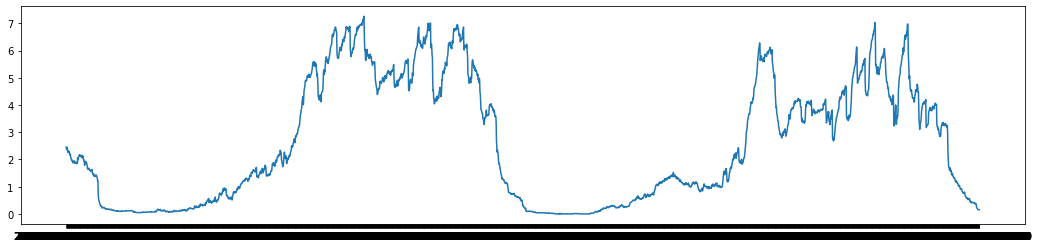

In [10]:
plt.figure(figsize=(18,4))
plt.plot(df1.truncate(before='2019-01-01 02:31:00', after='2019-01-03 02:31:00'))

In [ ]:
reseteo = pd.read_csv('df_ml.csv', index_col = 0)
reseteo.reset_index(drop=True, inplace=True)
reseteo.to_csv('df_ml.csv')